# Riemannian Brownian Mixture Model

In [1]:
#Modules

#jax
from jax import jacfwd, vmap, lax
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

#numpy
import numpy as np

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

#scores
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import diffusion_mean as dm_score
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.statistics.score_matching import BrownianMixtureGrad
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-05-09 17:27:18.704241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyper Parameters
T = 0.5
t0 = 0.01
score_path = "scores"
s2_approx = 0
s1loss_type = "dsm"
s2loss_type = "dsm"
s2_type = "s1s2"
seed = 2712
K = 4

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}_{s2loss_type}/"))
    layers_s1, layers_s2 = get_generator_dim(manifold, generator_dim)

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers_s1)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers_s2, layers_beta=layers_s2,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers_s1), 
                    models.MLP_s2(layers_alpha=layers_s2, 
                                  layers_beta=layers_s2,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval

In [4]:
def load_heat_model(manifold, dim, method="Local"):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1p_path = ''.join((score_path, f"/{manifold}{dim}/s1p_{s1loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)[0]

    s1p_model = hk.transform(lambda x: models.MLP_p(dim=generator_dim, layers=layers)(x))
        
    s1p_state = model_loader.load_model(s1p_path)
    
    rng_key = jrandom.PRNGKey(seed)
    
    if method == "Local":
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((x[0],y[0],t)))
    else:
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((M.F(x),M.F(y),t)))
                       
    return s1p_fun

## Testing with $\mathbb{R}^{2}$

In [5]:
M, x0, ScoreEval = load_score_model("Euclidean", 2)
s1p_fun = load_heat_model("Euclidean", 2)

using M.Exp for Logarithm
using M.Exp for Logarithm


### Generate Test Data

In [6]:
std = 0.1
x = []
centers = [jnp.array([-1.0,0.0]), jnp.array([0.0,1.0]), jnp.array([1.0,0.0]), jnp.array([0.0,-1.0])]
for i in range(K):
    eps = std*np.random.normal(size=(100,2))
    x.append(eps+centers[i])
x = jnp.vstack(x)

X_obs = (x, jnp.zeros(len(x)).reshape(-1))

### Testing with True Gradient

In [7]:
RBMM = BrownianMixtureGrad(M=M,
                           log_hk = M.log_hk, #s1p_fun
                           grady_log=lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                           gradt_log=M.gradt_log_hk,
                           n_clusters=4,
                           eps=0.1,
                           method='Local',
                           update_method="Gradient",
                           warmup=100,
                           max_iter=1000,
                           lr=0.1,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                          )

In [8]:
RBMM.fit((X_obs[0], X_obs[1].reshape(-1,1)))

In [9]:
T = RBMM.T
mu = RBMM.mu
gradt_log = vmap(lambda x,c: vmap(lambda mu_x, mu_c, t: M.gradt_log_hk((x,c),
                                                                       (mu_x, mu_c),
                                                                       t))(mu[0],
                                                                           mu[1],
                                                                           T))(X_obs[0],
                                                                               X_obs[1])

In [10]:
clusters = RBMM.classify(X_obs)

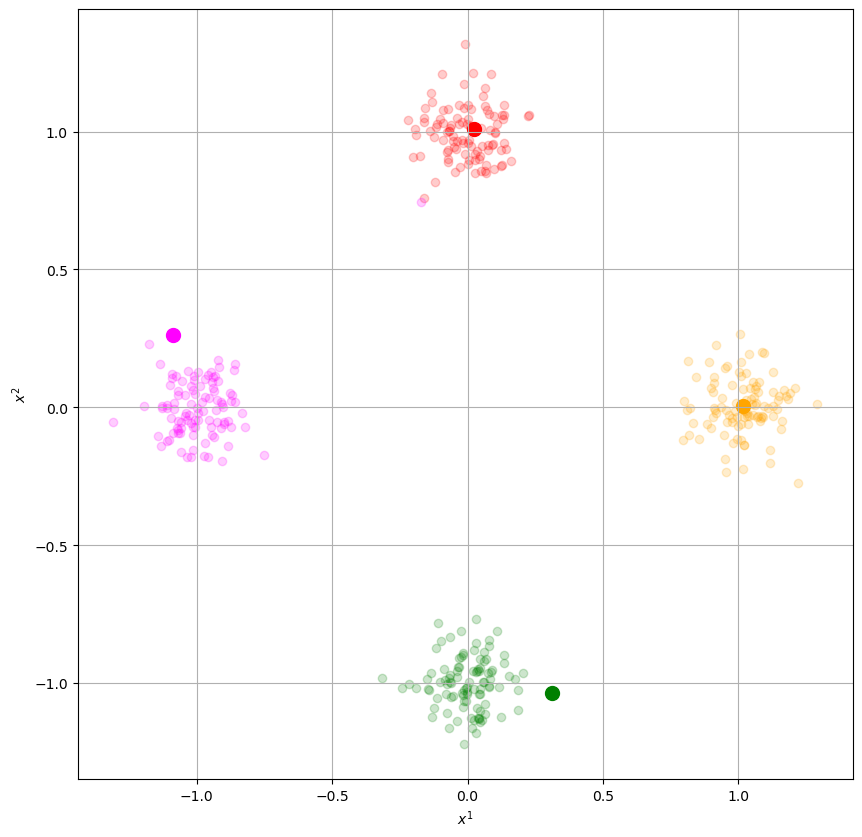

In [11]:
color = ['magenta', 'red', 'green', 'orange']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(K):
    ax.scatter(RBMM.mu[0][i,0], RBMM.mu[0][i,1], alpha=1.0, s=100, color=color[i])
    
for i in range(len(X_obs[0])):
    ax.scatter(X_obs[0][i,0], 
               X_obs[0][i,1], alpha=0.2, color=color[clusters[i]], label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

### Testing with Learned Gradient

In [20]:
RBMM = BrownianMixtureGrad(M=M,
                           log_hk = lambda x,y,t: lax.stop_gradient(s1p_fun(x,y,t)), #s1p_fun
                           grady_log=lambda x,y,t: lax.stop_gradient(ScoreEval.grady_log(x,y,t)),
                           gradt_log=lambda x,y,t: lax.stop_gradient(ScoreEval.gradt_log(x,y,t)),
                           n_clusters=4,
                           eps=0.1,
                           method='Local',
                           update_method="Gradient",
                           warmup=0,
                           max_iter=1000,
                           lr=0.1,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                          )

In [21]:
RBMM.fit((X_obs[0], X_obs[1].reshape(-1,1)))

In [22]:
T = RBMM.T
mu = RBMM.mu
gradt_log = vmap(lambda x,c: vmap(lambda mu_x, mu_c, t: M.gradt_log_hk((x,c),
                                                                       (mu_x, mu_c),
                                                                       t))(mu[0],
                                                                           mu[1],
                                                                           T))(X_obs[0],
                                                                               X_obs[1])

In [23]:
clusters = RBMM.classify(X_obs)

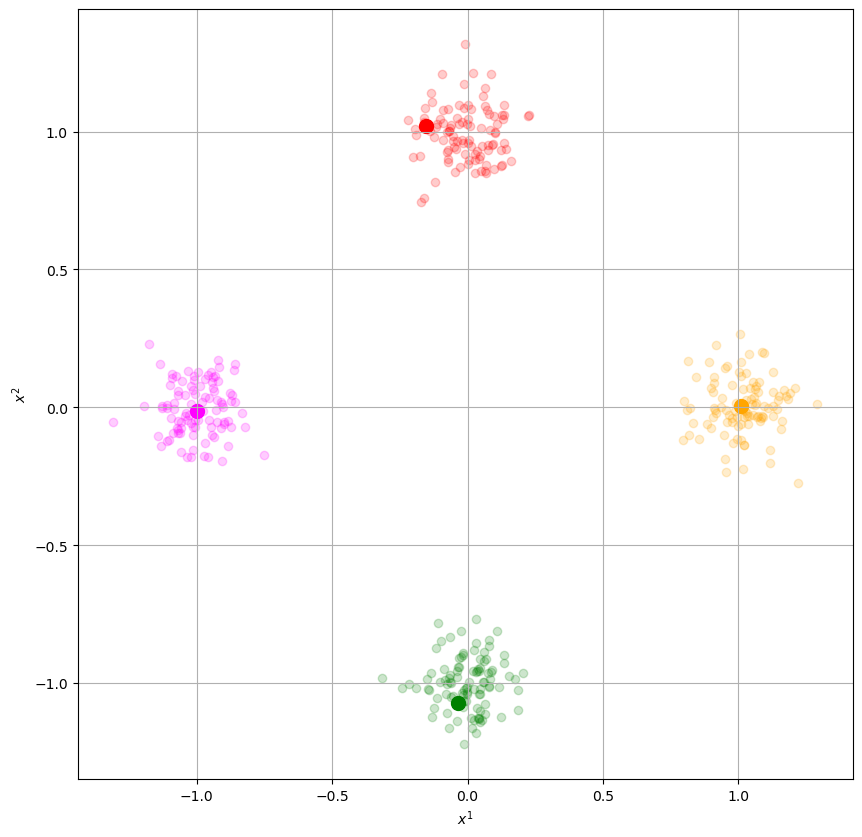

In [24]:
color = ['magenta', 'red', 'green', 'orange']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(K):
    ax.scatter(RBMM.mu[0][i,0], RBMM.mu[0][i,1], alpha=1.0, s=100, color=color[i])
    
for i in range(len(X_obs[0])):
    ax.scatter(X_obs[0][i,0], 
               X_obs[0][i,1], alpha=0.2, color=color[clusters[i]], label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)